Rough Notebook for data preparation for Neural Machine Translation 
from English to French Using Seq2Seq
 
Data link--> https://github.com/devm2024/nmt_keras/blob/master/fra.txt

Using Wget, I've downloaded data into 'data' directory

In [2]:
import numpy as np
import os
import re
import string
from pprint import pprint
import matplotlib.pyplot as plt
from nltk import FreqDist
plt.style.use('ggplot')

In [3]:
DATA_PATH = os.path.abspath('data/fra.txt')

In [4]:
# reading data
with open(DATA_PATH, 'r') as f:
    rawData = f.readlines()

In [5]:
print(len(rawData))
pprint(rawData[:5])

149861
['Go.\tVa !\n',
 'Run!\tCours\u202f!\n',
 'Run!\tCourez\u202f!\n',
 'Wow!\tÇa alors\u202f!\n',
 'Fire!\tAu feu !\n']


Hence we have 1,49,861 pairs of eng,french data where in each line eng-french are separated by Tab ('\t')

Initially I will keep the punctuations intact cause in the data punctuations are playing important role and I want the encoder-decoder to learn them

In [6]:
# all data to lower case
data = [s.lower() for s in rawData]

#removing punctuations
translateTable = str.maketrans('', '', string.punctuation)
data = [s.translate(translateTable) for s in data]
# striping '\n' and spliting on '\t'
# saving the data in tuple (eng, french)
dataEng = [d.rstrip('\n').split('\t')[0] for d in data]
pprint(dataEng[:5])
# alot of french text has '\u202f' character in the end, also strippping it
# Adding <GO> and <EOS> tokens in french as it will go in decoder
dataFr = [re.sub('\u202f', '', d.rstrip('\n').split('\t')[1]) for d in data]
pprint(dataFr[:5])

['go', 'run', 'run', 'wow', 'fire']
['va ', 'cours', 'courez', 'ça alors', 'au feu ']


Now building two different vocabs for french and english

In [7]:
wordIndexEngVocab = {}

wordIndexFrVocab = {}

# adding <GO> and <EOS> as 0 and 1 index in both vocabs
wordIndexEngVocab['<GO>'] = 0
wordIndexEngVocab['<EOS>'] = 1
startEngIndex = 2

wordIndexFrVocab['<GO>'] = 0
wordIndexFrVocab['<EOS>'] = 1
startFrIndex = 2

for sen in dataEng:
    for word in sen.split():
        if word not in wordIndexEngVocab:
            wordIndexEngVocab[word] = startEngIndex
            startEngIndex += 1
for sen in dataFr:
    for word in sen.split():
        if word not in wordIndexFrVocab:
            wordIndexFrVocab[word] = startFrIndex
            startFrIndex += 1

In [8]:
print('length of eng vocab: ', len(wordIndexEngVocab))
print('length of fr vocab: ', len(wordIndexFrVocab))

length of eng vocab:  14033
length of fr vocab:  28205


In [9]:
list(wordIndexFrVocab.keys())[28000:]

['despagnol',
 'contribuera',
 'afghanistan',
 'tourmenté',
 'flashbacks',
 'savérerait',
 'myrtilles',
 'cerises',
 'nectarines',
 'kigali',
 'antigouvernementales',
 'rwandaises',
 'bled',
 'manège',
 'démarche',
 'abraham',
 '16e',
 'fuste',
 'kentucky',
 'acheteur',
 'alarmante',
 'dalgèbre',
 'universitaires',
 'répugne',
 'citées',
 'lunesco',
 'ratatiné',
 'scanner',
 'téléchargerai',
 'peste',
 'usuel',
 'serveuses',
 'nemployant',
 'amincissait',
 'spécialisent',
 'missiles',
 'dixneufcentsoixantedeux',
 'sajustent',
 'réfrigéré',
 'lacidification',
 'menacera',
 'corail',
 'skinautique',
 'manifesta',
 'sinscrivent',
 'compositions',
 'écririons',
 'ramenait',
 'confirmation',
 'lactivation',
 'administrateur',
 'lanalyse',
 'éclaboussures',
 'substance',
 'résulte',
 'combustion',
 'incomplète',
 'carbonés',
 'subsides',
 'équation',
 'ciaprès',
 'quoiquimprobable',
 'réclamer',
 'imprononçables',
 'foutais',
 'prenaient',
 'hippopotame',
 'vieillissez',
 'arrêtent',
 'compl

In [10]:
# making inverse vocabs
indexWordEngVocab = dict( [(v, k) for k,v in wordIndexEngVocab.items() ] )
indexWordFrVocab = dict([ (v, k) for k,v in wordIndexFrVocab.items() ] )

Adding \<GO> and \<EOS> tokens at the start and end of french sentence as it will go into decoder

In [11]:
for i in range(len(dataFr)):
    dataFr[i] = ' '.join(['<GO>', dataFr[i], '<EOS>'])

In [12]:
dataFr[:15]

['<GO> va  <EOS>',
 '<GO> cours <EOS>',
 '<GO> courez <EOS>',
 '<GO> ça alors <EOS>',
 '<GO> au feu  <EOS>',
 '<GO> à laide <EOS>',
 '<GO> saute <EOS>',
 '<GO> ça suffit <EOS>',
 '<GO> stop <EOS>',
 '<GO> arrêtetoi  <EOS>',
 '<GO> attends  <EOS>',
 '<GO> attendez  <EOS>',
 '<GO> poursuis <EOS>',
 '<GO> continuez <EOS>',
 '<GO> poursuivez <EOS>']

Here we are not making the length of input to encoder and input to decoder variable length (i.e, dynamic)
Hence, we will make a plot of length of sentence V/s frequency (number of occurrence of that length) so as to choose the optimal length

In [13]:
seqLenListEng = [len(d.split()) for d in dataEng]
seqLenListFr = [len(d.split()) for d in dataFr]

distEng = dict(FreqDist(seqLenListEng))
distFr = dict(FreqDist(seqLenListFr))

Text(0.5,1,'For English Sentences')

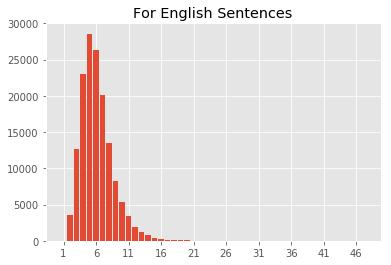

In [14]:
plt.close()
plt.bar(distEng.keys(), distEng.values())
plt.xticks(range(1, max(seqLenListEng), 5) )
plt.title('For English Sentences')

Text(0.5,1,'For English Sentences')

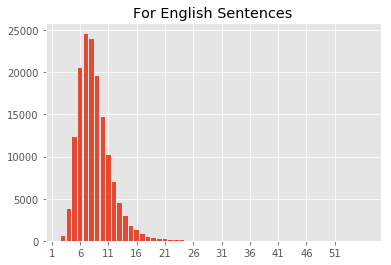

In [15]:
plt.close()
plt.bar(distFr.keys(), distFr.values())
plt.xticks(range(1, max(seqLenListFr), 5) )
plt.title('For English Sentences')

Hence we see that most of the sentences are having length around 10, and they are negligible 
after length 15, 
Hence we will sample only those data where the length of english sentence is less than 15 and french is less than 25

In [16]:
#dataEngNew = filter(lambda x: len(x.split()) >= 15, dataEng)
dataEngNew = []
dataFrNew = []
for i in range(len(dataEng)):
    if len(dataEng[i].split()) <= 15 and len(dataFr[i].split()) <= 25:
        dataEngNew.append(dataEng[i])
        dataFrNew.append(dataFr[i])

In [17]:
print('dropped sentences count: ', len(dataEng) - len(dataEngNew))

dropped sentences count:  754


# Building Model

In [18]:
# hyper-parameters
DATA_SIZE = len(dataEngNew)
ENCODER_TIME_STEPS = 15
DECODER_TIME_STEPS = 25
ENCODER_VOCAB_SIZE = len(wordIndexEngVocab)
DECODER_VOCAB_SIZE= len(wordIndexFrVocab)
EMBED_DIMS = 50
BATCH_SIZE = 64
ENCODER_HIDDEN_UNITS = 30
DECODER_HIDDEN_UNITS = 60
SEED = 2

In [19]:
# input variables
#encoder input -> (dataSize, encoderTimeSteps) 
# we will give all data and let keras generate batches
# here embedDims hasn't been added as 3rd dims because I will use keras to generate corresponding
# embedding
#decoder input -> (dataSize, decoderTimeSteps, decoderVocabSize) 
# as this is going to be softmax probabilty dist.
# decoder_target -> (dataSize, decoderTimeSteps decoderVocabSize)

# initializing variables
encoderInputsData = np.zeros((DATA_SIZE, ENCODER_TIME_STEPS), dtype=np.float64)
decoderInputsData = np.zeros((DATA_SIZE, DECODER_TIME_STEPS, DECODER_VOCAB_SIZE), dtype=np.float64)
decoderTargetsData = np.zeros((DATA_SIZE, DECODER_TIME_STEPS, DECODER_VOCAB_SIZE), dtype=np.float64)

# Note
Here, we need to understand that these input variables have been created with respect to 
training the encoder-decoder model. Hence irrespective of what decoder produes with initializing 
from encoder state, we have to give decoder ideal input as well as ideal target for output.
During testing, both decoderInputs and decoderTargets will be absent

In [ ]:
# adding data to input variables
for i, (engSen, frSen) in enumerate(zip(dataEngNew, dataFrNew)):
    #adding each word of a eng sen as time step into encoder ith input
    for t, word in enumerate(engSen.split()):
        encoderInputsData[i][t] = wordIndexEngVocab[word]
    
    # adding each word of corresponding french sen into decoder ith input
    for t, word in enumerate(frSen.split()):
        decoderInputsData[i][t] = wordIndexFrVocab[word]
        
        # decoder input word at t'th time step is the decoder target output for
        # t-1 th step
        if t>0:
            decoderTargetsData[i][t-1][wordIndexFrVocab[word]] = 1
            # here we will add 1 at the index of word which has to be target, 
            # as it is a prob dist of Fr vocab 

# Using Keras

In [20]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


Here Sequential Model hasn't been used, hence style is different

In [22]:
# initializing input tensor for encoder
encoderRawInp = Input(shape = (BATCH_SIZE,))

#creating encoder embeddings
encoderEmbed = Embedding(ENCODER_VOCAB_SIZE, EMBED_DIMS)
# replacing token with embedding
encoderInp = encoderEmbed(encoderRawInp)

# creating encoder
encoder = LSTM(ENCODER_HIDDEN_UNITS, return_state = True)
# return_state True,want encoder to return state also 

# encoder outputs and states
encoderOut, encoderStateH, encoderStateC = encoder(encoderInp)
encoderStates = [encoderStateH, encoderStateC]

In [ ]:
#initializing input tensor for decoder
decoderRawInp = Input(shape = (BATCH_SIZE,))

# creating decoder embeddings
decoderEmbed = Embedding(DECODER_VOCAB_SIZE, EMBED_DIMS)
decoderInp = decoderEmbed(decoderRawInp)

#creating decoder
decoder = LSTM(DECODER_HIDDEN_UNITS, return_state= True, return_sequences = True)
# here ret_seq is True as we want out of decoder at each time step
decoderOut, _, _ = decoder(decoderInp, initial_state = encoderStates)
# initialize decoder with encoder state